# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
display(sessions_history.head())
sessions_history.info()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique()
print(sessions_per_user)

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64


In [5]:
max_sessions = sessions_per_user.max()

# Найдем всех пользователей с максимальным количеством сессий
users_with_max_sessions = sessions_per_user[sessions_per_user == max_sessions].index.tolist()

# Выберем первого пользователя из списка
selected_user = users_with_max_sessions[0]

# Выведем все данные для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == selected_user]
print(user_data)

                 user_id        session_id session_date     session_start_ts  \
115558  10E0DEFC1ABDBBE0  B8F0423BBFFCF5DC   2025-08-14  2025-08-14 13:57:39   
191751  10E0DEFC1ABDBBE0  87CA2FA549473837   2025-08-15  2025-08-15 16:42:10   
239370  10E0DEFC1ABDBBE0  4ADD8011DCDCE318   2025-08-16  2025-08-16 19:53:21   
274629  10E0DEFC1ABDBBE0  DF0FD0E09BF1F3D7   2025-08-17  2025-08-17 15:03:43   
302501  10E0DEFC1ABDBBE0  3C221774B4DE6885   2025-08-18  2025-08-18 17:29:14   
325557  10E0DEFC1ABDBBE0  031BD7A67048105B   2025-08-19  2025-08-19 13:23:55   
345336  10E0DEFC1ABDBBE0  FF4315CF4AD4B100   2025-08-20  2025-08-20 19:31:54   
377532  10E0DEFC1ABDBBE0  4045FEA0747203B4   2025-08-22  2025-08-22 17:54:13   
403538  10E0DEFC1ABDBBE0  344B086C421C7F37   2025-08-24  2025-08-24 14:46:13   
414743  10E0DEFC1ABDBBE0  054F20BA371E4C9D   2025-08-25  2025-08-25 18:36:41   

       install_date  session_number  registration_flag  page_counter region  \
115558   2025-08-14               1     

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

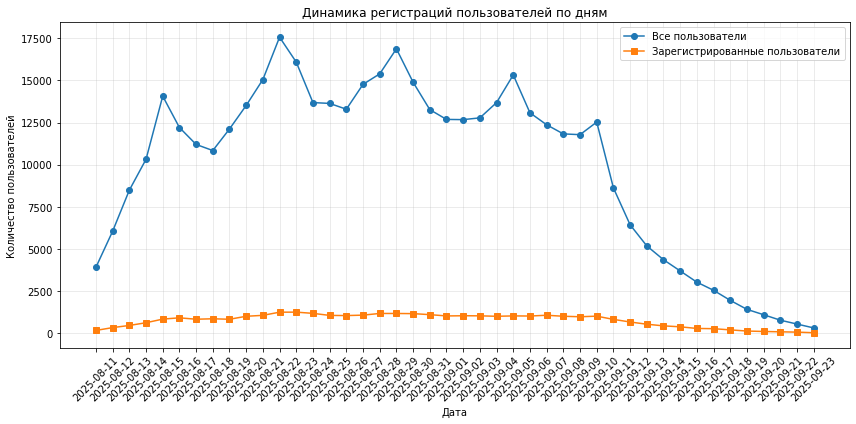

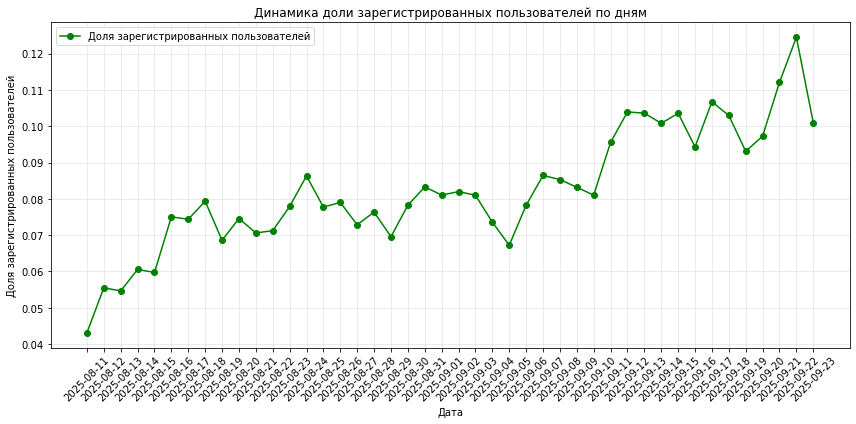

Агрегированные данные по дням:
   session_date  total_users  registered_users  registration_rate
0    2025-08-11         3919               169           0.043123
1    2025-08-12         6056               336           0.055482
2    2025-08-13         8489               464           0.054659
3    2025-08-14        10321               625           0.060556
4    2025-08-15        14065               840           0.059723
5    2025-08-16        12205               916           0.075051
6    2025-08-17        11200               833           0.074375
7    2025-08-18        10839               860           0.079343
8    2025-08-19        12118               831           0.068576
9    2025-08-20        13514              1008           0.074589
10   2025-08-21        15051              1063           0.070627
11   2025-08-22        17563              1251           0.071229
12   2025-08-23        16082              1253           0.077913
13   2025-08-24        13683              118

In [6]:
# Агрегируем данные по дням
daily_stats = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

# Рассчитываем долю зарегистрированных пользователей
daily_stats['registration_rate'] = daily_stats['registered_users'] / daily_stats['total_users']

# Создаем график с двумя линиями
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи', marker='o')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные пользователи', marker='s')

plt.title('Динамика регистраций пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Создаем график доли зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['registration_rate'], label='Доля зарегистрированных пользователей', color='green', marker='o')

plt.title('Динамика доли зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Выводим таблицу с агрегированными данными для проверки
print("Агрегированные данные по дням:")
print(daily_stats)

По первому графику видно, что большая часть пользователей сидит в приложении, будучи не зарегистрированными. Однако второй график показывает положительную динамику по количеству зарегистрированных пользователей.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

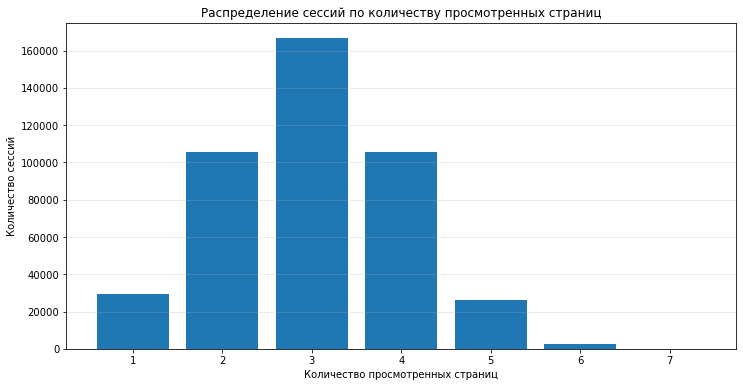

Количество сессий по числу просмотренных страниц:
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: page_counter, dtype: int64


In [7]:
page_sessions = sessions_history['page_counter'].value_counts().sort_index()

# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
plt.bar(page_sessions.index, page_sessions.values)

# Добавляем заголовок и подписи осей
plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')

# Добавляем сетку для удобства чтения
plt.grid(True, alpha=0.3, axis='y')

# Показываем график
plt.show()

# Выводим таблицу с данными для проверки
print("Количество сессий по числу просмотренных страниц:")
print(page_sessions)

Самое популярное количество просмотренных страниц - 3.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

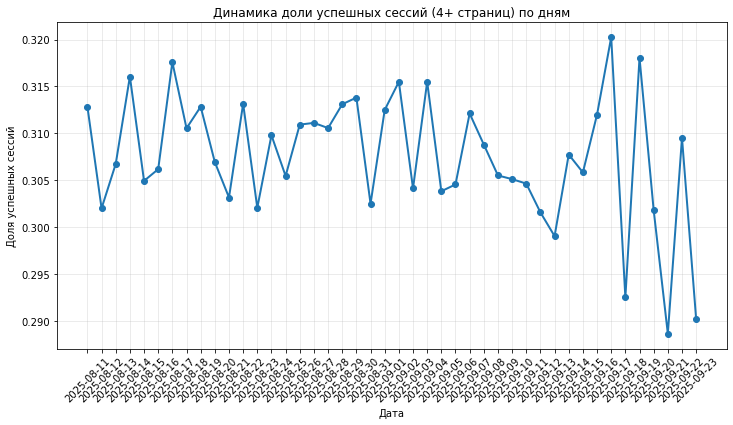

Первые 10 строк данных с новым столбцом:
         session_id  page_counter  good_session
0  F9AF61A0C2023832             3             0
1  85003A206CBDAC6F             4             1
2  3677423E49D72DEE             4             1
3  956B45F5915CA225             4             1
4  83BF0DA35F9F1F40             3             0
5  3AC48B25BA586DB3             3             0
6  F1A345355A8981FD             3             0
7  8EC5B17CA1ED5E10             5             1
8  E99DF62E41ECAB10             4             1
9  3F870A71E087CFE6             5             1

Доля успешных сессий по дням:
  session_date  good_session
0   2025-08-11      0.312835
1   2025-08-12      0.302015
2   2025-08-13      0.306750
3   2025-08-14      0.316055
4   2025-08-15      0.304941


In [8]:
# Создаем столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Агрегируем данные по дням - считаем долю успешных сессий
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session'], marker='o', linewidth=2)

# Добавляем заголовок и подписи осей
plt.title('Динамика доли успешных сессий (4+ страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True, alpha=0.3)

# Поворачиваем подписи дат для лучшей читаемости
plt.xticks(rotation=45)
plt.show()

# Выводим первые строки для проверки
print("Первые 10 строк данных с новым столбцом:")
print(sessions_history[['session_id', 'page_counter', 'good_session']].head(10))

print("\nДоля успешных сессий по дням:")
print(daily_good_sessions.head())

Доля удачных сессий держится примерно на одном уровне - 30%.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Метрика: Доля успешных сессий (просмотр 4+ страниц) - good_session

Формулировка гипотез:

Нулевая гипотеза (H₀):
Новый алгоритм рекомендаций не влияет на долю успешных сессий.
Доля сессий с просмотром 4+ страниц в тестовой группе (новый алгоритм) равна или меньше доли в контрольной группе (старый алгоритм).

H0: p_a ≤ p_b

Альтернативная гипотеза (H₁):
Новый алгоритм рекомендаций увеличивает долю успешных сессий.
Доля сессий с просмотром 4+ страниц в тестовой группе (новый алгоритм) больше доли в контрольной группе (старый алгоритм).

H1: p_a > p_b

Обоснование:
Поскольку команда утверждает, что новый алгоритм будет показывать "более интересный контент", это должно привести к увеличению вовлеченности пользователей, что проявляется в росте доли сессий с глубоким просмотром контента (4+ страниц).

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [9]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [10]:
from math import ceil

sample_size = 41040

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users:.0f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [11]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
display(sessions_test_part.head())
sessions_test_part.info()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


Количество уникальных пользователей по группам:
test_group
A    1477
B    1466
Name: user_id, dtype: int64

Процентная разница между группой B и группой A: -0.74%


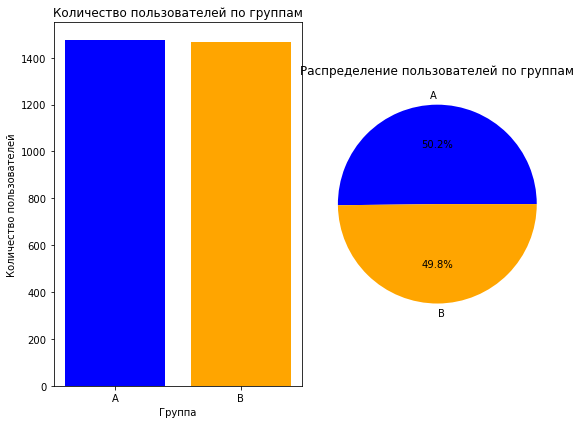

In [12]:
# Количество уникальных пользователей в каждой группе за день
users_per_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

print("Количество уникальных пользователей по группам:")
print(users_per_group)

# Расчет процентной разницы
users_a, users_b = users_per_group['A'], users_per_group['B']


if users_a > 0:
    percentage_difference = ((users_b - users_a) / users_a) * 100
else:
    percentage_difference = 0

print(f"\nПроцентная разница между группой B и группой A: {percentage_difference:.2f}%")

# Визуализация
plt.figure(figsize=(8, 6))

# Столбчатая диаграмма
plt.subplot(1, 2, 1)
plt.bar(users_per_group.index, users_per_group.values, color=['blue', 'orange'])
plt.title('Количество пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')

# Круговая диаграмма
plt.subplot(1, 2, 2)
plt.pie(users_per_group.values, labels=users_per_group.index, autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Распределение пользователей по группам')

plt.tight_layout()
plt.show()

Пользователи разделены практически поровну.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [13]:
# Группируем по пользователям и считаем количество уникальных групп
user_groups = sessions_test_part.groupby('user_id')['test_group'].nunique()

# Находим пользователей, которые были более чем в одной группе
overlapping_users = user_groups[user_groups > 1]

print(f"Количество пользователей в обеих группах: {len(overlapping_users)}")

if len(overlapping_users) == 0:
    print("Группы независимы - пересечений нет")
else:
    print("Обнаружены пользователи в обеих группах")
    print(overlapping_users.index.tolist())

Количество пользователей в обеих группах: 0
Группы независимы - пересечений нет


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


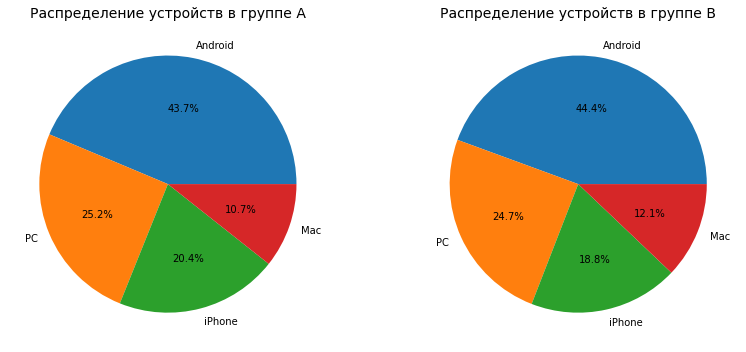

In [14]:
# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Группа A
device_counts_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['device'].value_counts()
ax1.pie(device_counts_a.values, labels=device_counts_a.index, autopct='%1.1f%%')
ax1.set_title('Распределение устройств в группе A', fontsize=14)

# Группа B
device_counts_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['device'].value_counts()
ax2.pie(device_counts_b.values, labels=device_counts_b.index, autopct='%1.1f%%')
ax2.set_title('Распределение устройств в группе B', fontsize=14)

plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


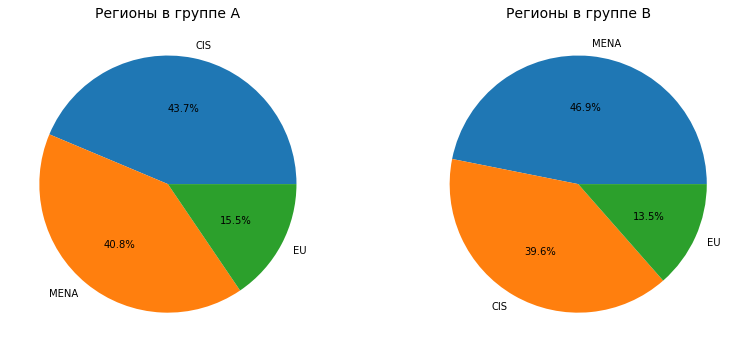

In [15]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))

# Регионы - группа A
region_counts_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['region'].value_counts()
ax3.pie(region_counts_a.values, labels=region_counts_a.index, autopct='%1.1f%%')
ax3.set_title('Регионы в группе A', fontsize=14)

# Регионы - группа B
region_counts_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['region'].value_counts()
ax4.pie(region_counts_b.values, labels=region_counts_b.index, autopct='%1.1f%%')
ax4.set_title('Регионы в группе B', fontsize=14)

plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

Различие в количестве пользователей по группам есть, но оно минимально - всего 11 человек. На тест эта разница никак не повляет. Выборки являются независимыми, пересечение пользователей не обнаружено.  По графикам видно, что ользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам. Тест проходит корректно, нарушения не наблюдаются. 


### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [16]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
display(sessions_test_part.head())
sessions_test_part.info()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [21]:
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Разделяем на две группы
group_a = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
group_b = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']

print(f"Среднее количество сессий в группе A: {group_a.mean():.2f}")
print(f"Среднее количество сессий в группе B: {group_b.mean():.2f}")

_, p_value = stats.ttest_ind(group_a, group_b)
test_name = "t-тест"

print(f"\nРезультат статистического теста ({test_name}):")
print(f"p-value = {p_value:.4f}")

alpha = 0.05

if p_value > alpha:
    print("\nНулевая гипотеза не отвергается")
    print("Статистически значимых различий в количестве сессий между группами A и B НЕТ")
    print("Группы сопоставимы по количеству сессий")
else:
    print("\nНулевая гипотеза отвергается")
    print("Обнаружены статистически значимые различия в количестве сессий между группами A и B")
    print("Группы НЕ сопоставимы по количеству сессий")

Среднее количество сессий в группе A: 2477.55
Среднее количество сессий в группе B: 2522.70

Результат статистического теста (t-тест):
p-value = 0.9382

Нулевая гипотеза не отвергается
Статистически значимых различий в количестве сессий между группами A и B НЕТ
Группы сопоставимы по количеству сессий


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [29]:
# Создаем столбец good_session (если еще не создан)
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Рассчитываем долю успешных сессий для каждой группы
good_sessions_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
good_sessions_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()

# Рассчитываем разницу
difference = good_sessions_b - good_sessions_a
relative_difference = (difference / good_sessions_a) * 100

# Выводим результаты
print("СРАВНЕНИЕ ДОЛИ УСПЕШНЫХ СЕССИЙ:")
print(f"Группа A (контрольная): {good_sessions_a:.4f} ({good_sessions_a*100:.2f}%)")
print(f"Группа B (тестовая):    {good_sessions_b:.4f} ({good_sessions_b*100:.2f}%)")
print(f"Абсолютная разница:     {difference:.3f}")

СРАВНЕНИЕ ДОЛИ УСПЕШНЫХ СЕССИЙ:
Группа A (контрольная): 0.3077 (30.77%)
Группа B (тестовая):    0.3183 (31.83%)
Абсолютная разница:     0.011


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [30]:
# Подготовка данных для теста
success_a = sessions_test[(sessions_test['test_group'] == 'A') & (sessions_test['good_session'] == 1)].shape[0]
success_b = sessions_test[(sessions_test['test_group'] == 'B') & (sessions_test['good_session'] == 1)].shape[0]

total_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]
total_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]

# Проводим Z-тест для пропорций
# alternative='larger' - тестируем гипотезу, что доля в группе B больше чем в группе A
z_stat, p_value = proportions_ztest(
    count=[success_b, success_a],  # [успехи в группе B, успехи в группе A]
    nobs=[total_b, total_a],       # [общее в группе B, общее в группе A]
    alternative='larger'           # тестируем, что B > A
)

print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ ИЗМЕНЕНИЯ")
print(f"Группа A: {success_a}/{total_a} успешных сессий ({success_a/total_a*100:.2f}%)")
print(f"Группа B: {success_b}/{total_b} успешных сессий ({success_b/total_b*100:.2f}%)")
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05
print("\nВЫВОД:")
if p_value < alpha:
    print(f"p-value ({p_value:.4f}) < уровня значимости ({alpha})")
    print("Изменение доли успешных сессий статистически значимо, нулевая гипотеза отвергается в пользу альтернативной")
else:
    print(f"p-value ({p_value:.4f}) ≥ уровня значимости ({alpha})")
    print("Изменение доли успешных сессий НЕ статистически значимо, нулевая гипотеза не отвергается")

ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ ИЗМЕНЕНИЯ
Группа A: 15248/49551 успешных сессий (30.77%)
Группа B: 16059/50454 успешных сессий (31.83%)
Z-статистика: 3.6027
p-value: 0.0002

ВЫВОД:
p-value (0.0002) < уровня значимости (0.05)
Изменение доли успешных сессий статистически значимо, нулевая гипотеза отвергается в пользу альтернативной


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

Количество задействованных пользователей - примерно 1500 на каждую группу. Длительность теста составила 9 дней. Внедрение нового алгоритма повлияло на рост ключевой метрики. Доля ключевой метрики выросла. Значение p-value для оценки статистической значимости выявленного эффекта - 0.0002. По результатам анализа, внедрять нововведение в приложение стоит, так как проведение A/B-теста показало положительную динамику. 